<a href="https://colab.research.google.com/github/ashithapallath/NER-Using-HMM/blob/main/HMMModelNER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from collections import defaultdict
import pandas as pd
import ast
from tabulate import tabulate
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
class HMM:
    def __init__(self, states, observations):
        """
        The initialization of the HMM class with states, observations, and probability matrices has been done.
        The use of dictionaries (state_index and observation_index) for indexing states and observations avoids potential indexing errors.
        """
        self.states = states
        self.observations = observations
        self.start_probabilities = np.zeros(len(states))
        self.transition_probabilities = np.zeros((len(states), len(states)))
        self.emission_probabilities = np.zeros((len(states), len(observations)))

        self.state_index = {state: i for i, state in enumerate(states)}
        self.observation_index = {obs: i for i, obs in enumerate(observations)}

    def compute_start_probabilities(self, sequences):
        """
        The computation of start probabilities based on the first tag of each sequence is appropriate.
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            start_state = sequence[0][1]
            self.start_probabilities[self.state_index[start_state]] += 1
        self.start_probabilities /= np.sum(self.start_probabilities)

    def compute_transition_probabilities(self, sequences):
        """
        The computation of transition probabilities between states is implemented correctly.
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            for i in range(len(sequence) - 1):
                current_state = sequence[i][1]
                next_state = sequence[i + 1][1]
                self.transition_probabilities[self.state_index[current_state], self.state_index[next_state]] += 1

        for i in range(len(self.states)):
            if(np.sum(self.transition_probabilities[i])==0):
                continue
            self.transition_probabilities[i] /= np.sum(self.transition_probabilities[i])

    def compute_emission_probabilities(self, sequences):
        """
        The computation of emission probabilities from states to observations is well-implemented.
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            for token, state in sequence:
                self.emission_probabilities[self.state_index[state], self.observation_index[token]] += 1

        for i in range(len(self.states)):
            if(np.sum(self.emission_probabilities[i])==0):
                continue
            self.emission_probabilities[i] /= np.sum(self.emission_probabilities[i])

    def viterbi_algorithm(self, obs):
        """
        The Viterbi algorithm is correctly implemented with the necessary tables for probabilities and backpointers.
        The logic for finding the best path is accurate.
        We have handled the case when an out of vocabulary word is encountered.
        """

        viterbi_table = [[0.0 for _ in range(len(self.states))] for _ in range(len(obs))]
        backpointer = [[0 for _ in range(len(self.states))] for _ in range(len(obs))]

        for t in range(len(obs)):
            for s in range(len(self.states)):
                if t == 0:
                    viterbi_table[t][s] = self.start_probabilities[s] * self.emission_probabilities[s][obs[t]]
                else:
                    max_prob = -1
                    max_backpointer = -1

                    for s_prime in range(len(self.states)):
                        prob = viterbi_table[t-1][s_prime] * self.transition_probabilities[s_prime][s] * self.emission_probabilities[s][obs[t]]
                        if prob > max_prob:
                            max_prob = prob
                            max_backpointer = s_prime

                    viterbi_table[t][s] = max_prob
                    backpointer[t][s] = max_backpointer

        best_path_pointer = max(range(len(self.states)), key=lambda s: viterbi_table[-1][s])
        best_path = [best_path_pointer]

        for t in range(len(obs)-1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])

        return best_path

In [ ]:
def threshold_data(sequences, threshold):
    word_counts = defaultdict(int)
    for sequence in sequences:
        for token, state in sequence:
            word_counts[token] += 1

    unk_sequences = []
    for sequence in sequences:
        unk_sequence = [(token if word_counts[token] > threshold else 'UNK', state) for token, state in sequence]
        unk_sequences.append(unk_sequence)

    return unk_sequences

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:

# Load the dataset
from datasets import load_dataset
dataset = load_dataset("ai4bharat/naamapadam","ml")

# If you want to load both the train and test splits
train_data = dataset['train']
test_data = dataset['test']


print(train_data[0])
print(test_data[0])
# Convert to pandas DataFrame for easier processing (if needed)
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# If the dataset has 'tokens' and 'ner_tags' columns, convert them accordingly
# Assuming the columns in the dataset are similar to 'tokens' and 'ner_tags'
# Instead of using ast.literal_eval directly, try this:
train_df['tokens'] = train_df['tokens'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
train_df['ner_tags'] = train_df['ner_tags'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

test_df['tokens'] = test_df['tokens'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
test_df['ner_tags'] = test_df['ner_tags'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

naamapadam.py:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/61.8M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/81.5k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/315k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/716652 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/974 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3618 [00:00<?, ? examples/s]

{'tokens': ['1824', '-', 'ൽ', 'ഇത്', 'സാൻ', 'ഗബ്രിയൽ', 'ആർക്കാൻഗൽ', 'മിഷന്റെ', 'ഭാഗമായും', 'തുടർന്ന്', 'റാഞ്ചോ', 'സാൻ', 'ഗോർഗോനിയോയുടെയും', 'ഭാഗമായി', 'മാറി', '.'], 'ner_tags': [0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 3, 4, 4, 0, 0, 0]}
{'tokens': ['കോൺഗ്രസ്', 'സംസ്ഥാന', 'അധ്യക്ഷൻ', 'ജി', 'പരമേശ്വര', 'ഉപമുഖ്യമന്ത്രിയാകും', '.'], 'ner_tags': [3, 0, 0, 1, 2, 0, 0]}


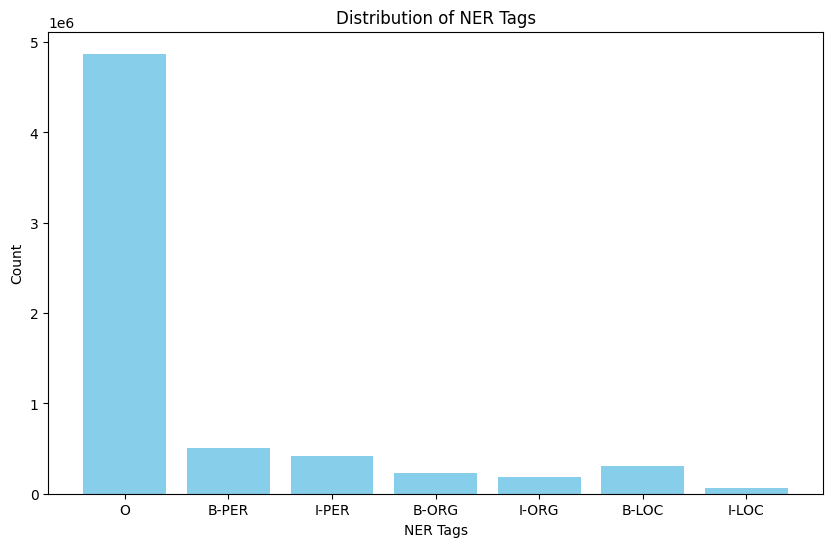

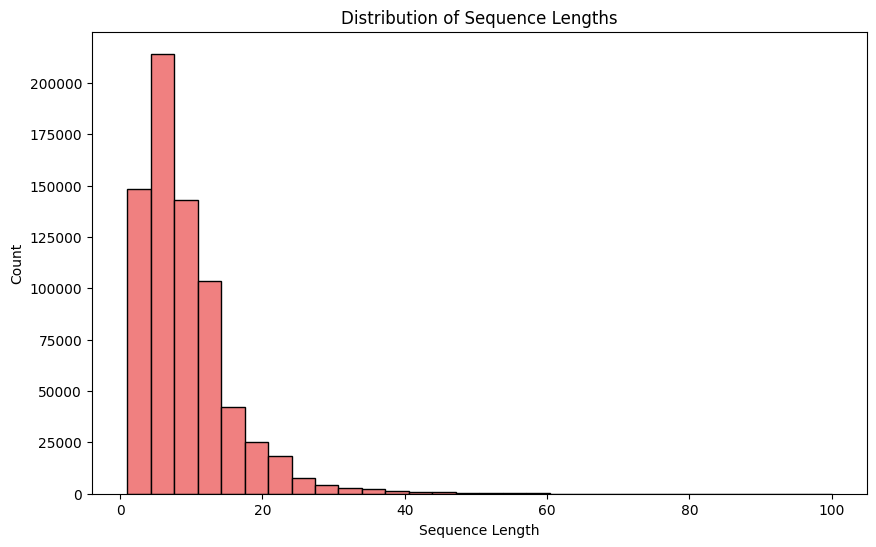

Number of unique tokens: 620637


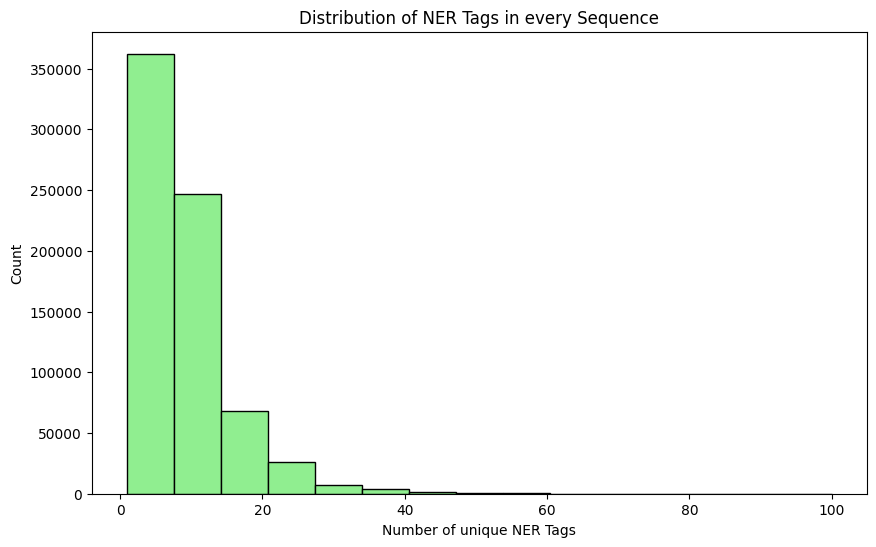

In [ ]:
ner_distribution = train_df['ner_tags'].explode().value_counts().sort_index() # Changed df_train_combined to train_df
ner_tags = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

train_df['sequence_length'] = train_df['tokens'].apply(len) # Changed df_train_combined to train_df
plt.figure(figsize=(10, 6))
plt.hist(train_df['sequence_length'], bins=30, color='lightcoral', edgecolor='black') # Changed df_train_combined to train_df
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = train_df['tokens'].explode().nunique() # Changed df_train_combined to train_df
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = train_df['ner_tags'].apply(len) # Changed df_train_combined to train_df
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()

In [ ]:
def train_hmm(hmm_model, sequences):
    hmm_model.compute_start_probabilities(sequences)
    hmm_model.compute_transition_probabilities(sequences)
    hmm_model.compute_emission_probabilities(sequences)

In [ ]:
def get_hmm_model(train_df, test_df):
    train_data = [(row['tokens'], row['ner_tags']) for _, row in train_df.iterrows()]
    unique_tags = set(tag for _, tags in train_data for tag in tags)
    states = list(unique_tags)
    sequences = [list(zip(tokens, tags)) for tokens, tags in train_data]
    sequences = threshold_data(sequences, 5)

    unique_tokens = set()
    for sequence in sequences:
        for token, _ in sequence:
            unique_tokens.add(token)

    unique_tokens_list = list(unique_tokens)

    hmm_model = HMM(states, unique_tokens_list)

    train_hmm(hmm_model, sequences)

    test_tokens = test_df['tokens']
    test_ner_tags = test_df['ner_tags']

    N_test = len(test_tokens)

    return hmm_model, N_test, test_tokens, test_ner_tags, states

## Training the HMM Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from seaborn import heatmap
import seaborn as sns

def compute_metrics(true_tags, predicted_tags, accuracy, states):
    # Exclude state 0 (OTHER) from the list of states
    states = [state for state in states if state != 0]

    print("\nOverall Metrics (excluding 'OTHER'):")
    print("Accuracy:", accuracy)
    print(classification_report(true_tags, predicted_tags, zero_division=1, labels=states))

    print("\nPer-State Metrics (excluding 'OTHER'):")
    per_state_report = classification_report(true_tags, predicted_tags, labels=states, output_dict=True, zero_division=1)

    precision_values = [per_state_report[str(state)]['precision'] for state in states]
    recall_values = [per_state_report[str(state)]['recall'] for state in states]
    f1_score_values = [per_state_report[str(state)]['f1-score'] for state in states]
    support_values = [per_state_report[str(state)]['support'] for state in states]
    state_accuracy_values = [
        sum(1 for true, pred in zip(true_tags, predicted_tags) if true == state and pred == state) / true_tags.count(state) if true_tags.count(state) > 0 else 0
        for state in states
    ]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    fig.suptitle("Metrics Comparison for Different Entity Types (excluding 'OTHER')", fontsize=16)

    axes[0, 0].bar(states, precision_values, color='skyblue')
    axes[0, 0].set_title("Precision")
    axes[0, 0].set_ylabel("Score")

    axes[0, 1].bar(states, recall_values, color='lightcoral')
    axes[0, 1].set_title("Recall")
    axes[0, 1].set_ylabel("Score")

    axes[1, 0].bar(states, f1_score_values, color='lightgreen')
    axes[1, 0].set_title("F1-Score")
    axes[1, 0].set_ylabel("Score")

    support_bars = axes[1, 1].bar(states, support_values, color='gold')
    axes[1, 1].set_title("Support")
    axes[1, 1].set_ylabel("Count")

    for bar, support_value in zip(support_bars, support_values):
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(support_value), ha='center', va='bottom')

    axes[2, 0].bar(states, state_accuracy_values, color='orchid')
    axes[2, 0].set_title("State-wise Accuracy")
    axes[2, 0].set_ylabel("Accuracy")

    fig.delaxes(axes[2, 1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nConfusion Matrix (excluding 'OTHER'):")
    plt.figure(figsize=(16, 10))
    conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=states)
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=states, yticklabels=states)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (excluding 'OTHER')")
    plt.show()

In [ ]:
def plot_misclassification_rates(states, true_tags, predicted_tags):
    misclassification_rates = {state: 0 for state in states}

    for true_tag, predicted_tag in zip(true_tags, predicted_tags):
        if true_tag != predicted_tag:
            misclassification_rates[true_tag] += 1

    misclassification_rates = {
        state: misclassification_rates[state] / true_tags.count(state) if true_tags.count(state) > 0 else 0
        for state in states
    }

    sorted_states = sorted(states, key=lambda state: misclassification_rates[state], reverse=True)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_states, [misclassification_rates[state] for state in sorted_states], color='coral')
    plt.xlabel("Entity Types")
    plt.ylabel("Misclassification Rate")
    plt.title("Misclassification Rates for Different Entity Types")
    plt.show()

In [ ]:
def evaluate_model(hmm_model, test_ner_tags, test_tokens, N_test, states):
    true_tags_all = []
    predicted_tags_all = []

    correct = 0
    total = 0
    for idx in range(N_test):
        tags = test_ner_tags[idx] # Changed: Removed eval and directly accessed the list
        observations = test_tokens[idx] # Changed: Removed eval and directly accessed the list
        if len(observations) == 0:
            continue

        observed_tokens = test_ner_tags[idx] # Changed: Removed eval and directly accessed the list
        # observation_indices = [hmm_model.observation_index.get(obs, len(hmm_model.observations)) for obs in observations]

        observation_indices = [
            hmm_model.observation_index[obs] if obs in hmm_model.observation_index else hmm_model.observation_index['UNK']
            for obs in observations
        ]

        predicted_tags = hmm_model.viterbi_algorithm(observation_indices)

        true_tags_all.extend(tags)
        predicted_tags_all.extend([states[tag] for tag in predicted_tags])

        for i in range(len(predicted_tags)):
            if predicted_tags[i] == observed_tokens[i]:
                correct += 1

        total += len(observations)

    accuracy = correct / total

    compute_metrics(true_tags_all, predicted_tags_all, accuracy, states)
    plot_misclassification_rates(states, true_tags_all, predicted_tags_all)

In [ ]:
hmm_model_combined, N_test_combined, test_tokens_combined, test_ner_tags_combined, states  = get_hmm_model(train_df, test_df)


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.8870400749941411
              precision    recall  f1-score   support

           1       0.89      0.77      0.83       714
           2       0.86      0.81      0.84       629
           3       0.81      0.59      0.68       309
           4       0.54      0.45      0.49       249
           5       0.92      0.71      0.80       482
           6       0.49      0.37      0.42        99

   micro avg       0.83      0.70      0.76      2482
   macro avg       0.75      0.62      0.68      2482
weighted avg       0.83      0.70      0.76      2482


Per-State Metrics (excluding 'OTHER'):


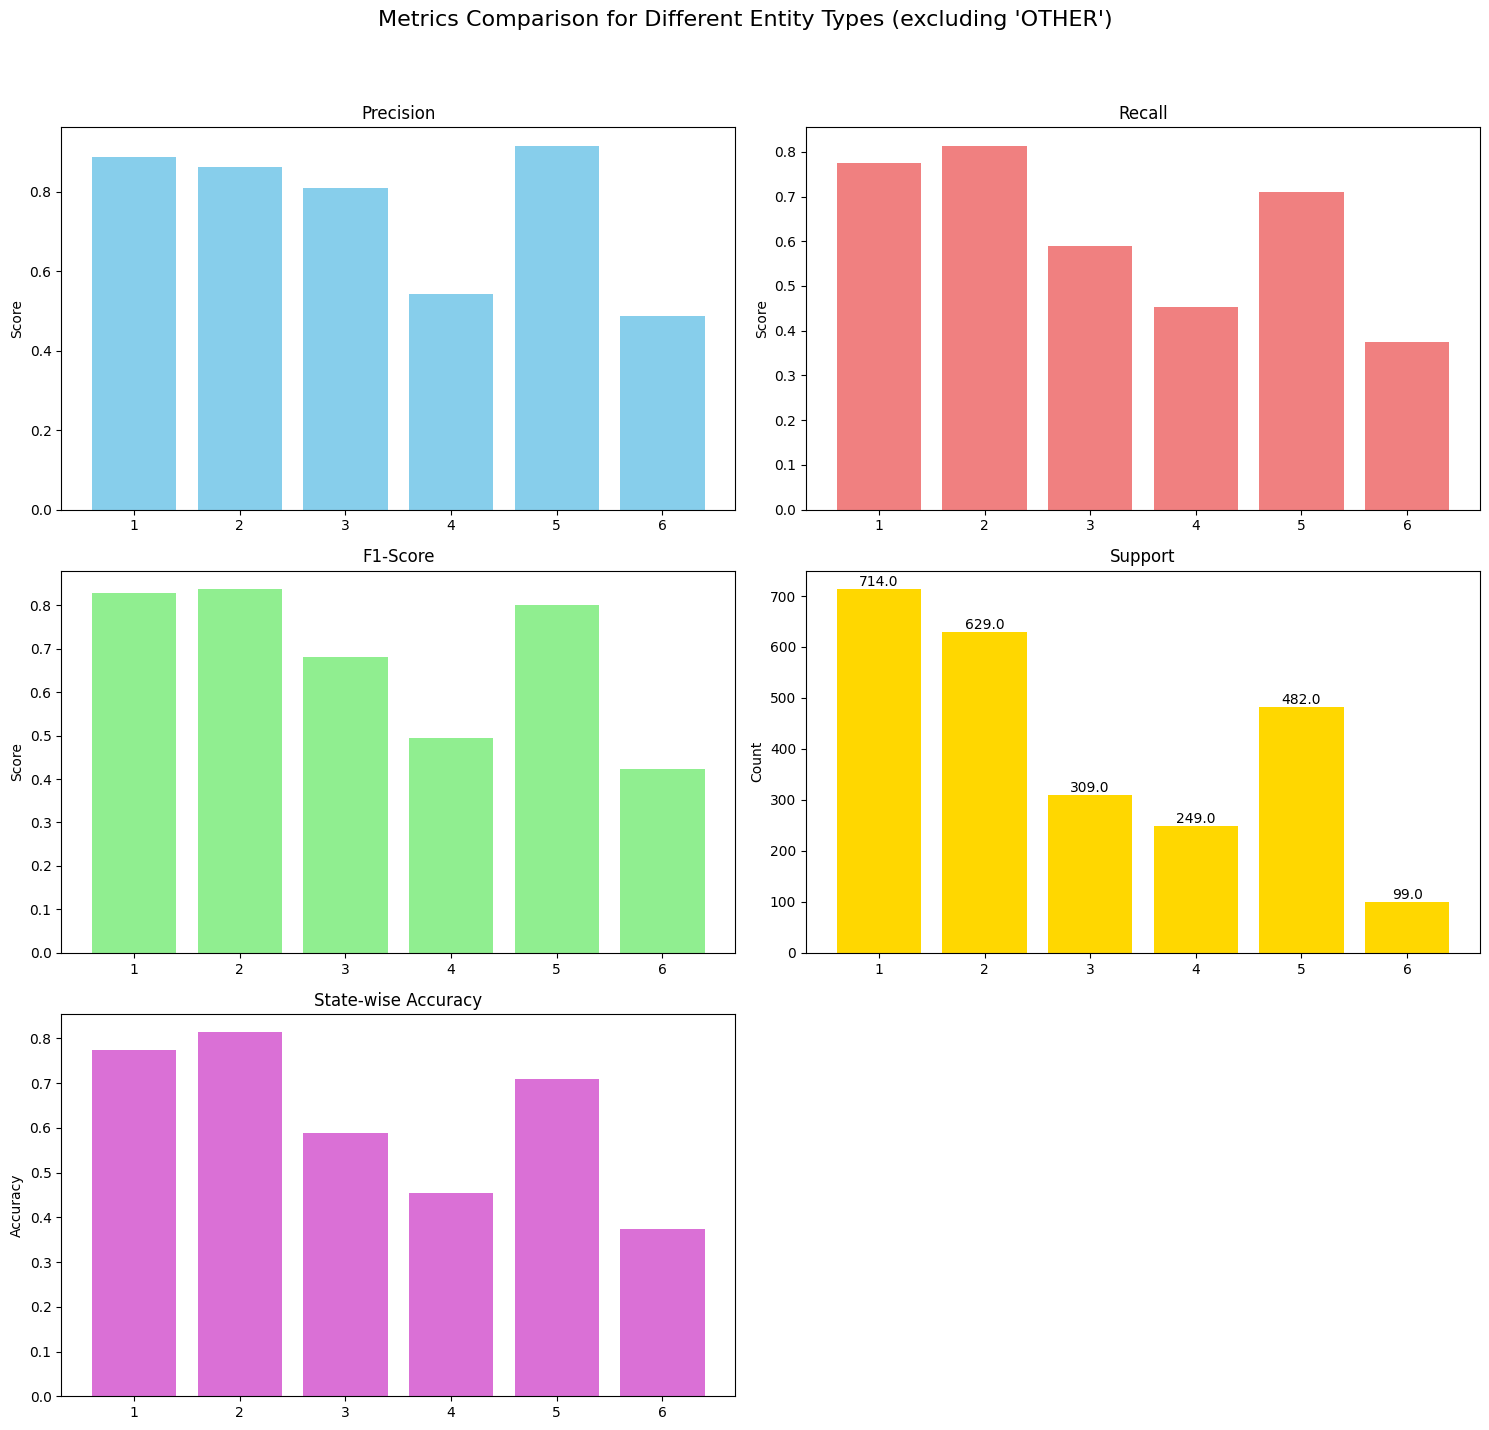


Confusion Matrix (excluding 'OTHER'):


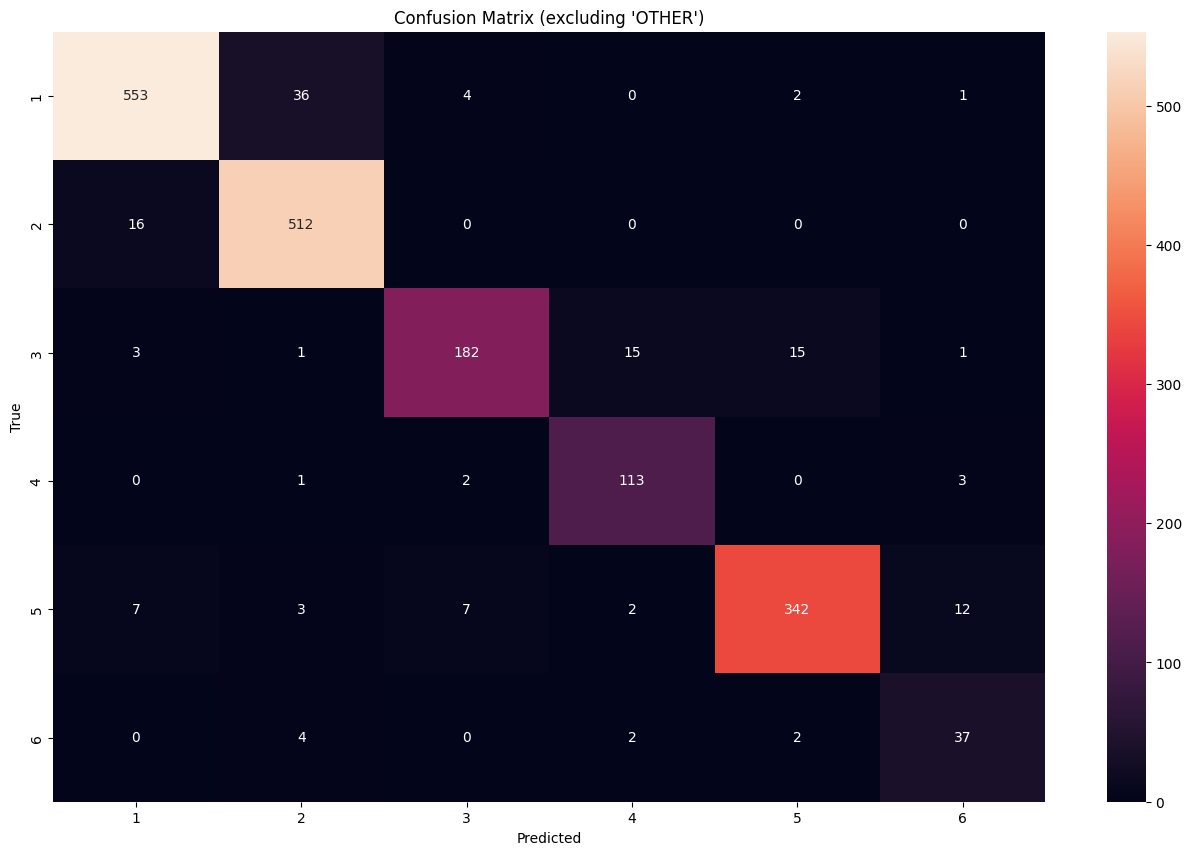

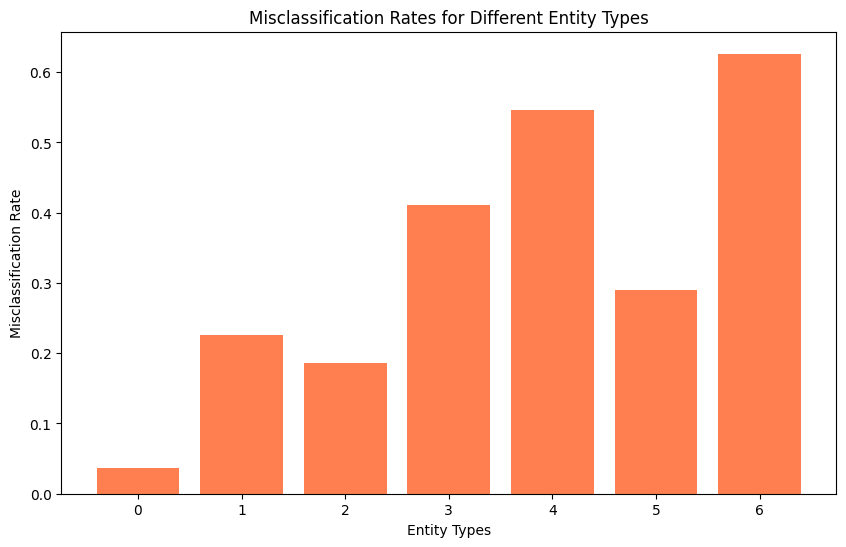

In [ ]:
evaluate_model(hmm_model_combined, test_ner_tags_combined, test_tokens_combined, N_test_combined, np.arange(len(ner_tags)))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Assign the trained HMM model to the ner_model variable
ner_model = hmm_model_combined

# Sample sentence to test

#sample_sentence = "കോൺഗ്രസ് സംസ്ഥാന അധ്യക്ഷൻ ജി പരമേശ്വര ഉപമുഖ്യമന്ത്രിയാകും ."
# sample_sentence = "എയർ ഇന്ത്യ ഒരു വിമാന കമ്പനിയാണ്"
# sample_sentence = "കേരളം ഇന്ത്യയിലെ ഒരു സംസ്ഥാനമാണ്"
sample_sentence = "സുന്ദർ പിച്ചൈ ഗൂഗിളിന്റെ സിഇഒ ആണ്"
# sample_sentence="ഹിമാലയ പർവതം നേപ്പാളിൽ സ്ഥിതി ചെയ്യുന്നു"

# Step 1: Tokenize the sample sentence (assuming it’s pre-tokenized)
tokens = sample_sentence.split()  # Simple whitespace-based tokenization


# Get observation indices for the tokens
observation_indices = [
    ner_model.observation_index[obs] if obs in ner_model.observation_index else ner_model.observation_index['UNK']
    for obs in tokens
]

# Use the Viterbi algorithm for prediction
predicted_tags = ner_model.viterbi_algorithm(observation_indices)



# Map the predicted tags to NER labels using ner_tags and states
predicted_labels = [ner_tags[state] for state in predicted_tags]

# Step 4: Print the tokens along with the predicted labels
print("Tokens and Predicted NER Tags:")
for token, label in zip(tokens, predicted_labels):
    print(f"{token}: {label}")

Tokens and Predicted NER Tags:
സുന്ദർ: B-PER
പിച്ചൈ: I-PER
ഗൂഗിളിന്റെ: O
സിഇഒ: O
ആണ്: O
